In [ ]:
# Install the required libraries.
!pip install tensorflow opencv-contrib-python moviepy pydot mediapipe

In [ ]:
# Import the required libraries.
import os
import cv2
from google.colab.patches import cv2_imshow
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 50

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/content/drive/MyDrive/UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["PushUps", "TennisSwing", "BaseballPitch", "Biking", "PlayingViolin", "Lunges", "JumpingJack", "PullUps", "GolfSwing", "SoccerJuggling"]


In [ ]:
#creat dataset output path 

#path to stock landmarks
DATA_RESULTS = "/content/drive/MyDrive/landmarks_new"

In [ ]:
import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [ ]:
def landmarks_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video landmarks.
    landMarks = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #print("nombre des frames",video_frames_count)

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = 1
    
    # start frame
    index = int((video_frames_count - 50 ) / 2)

# Run MediaPipe Pose and draw pose landmarks.
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
      
    
    # Iterate through the Video Frames.
        for frame_counter in range(index , index + 50):
      
          #print(frame_counter)
          # Set the current frame position of the video.
          video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window)
        
          # Reading the frame from the video. 
          success, frame = video_reader.read()
        
       
          # Check if Video frame is not successfully read then break the loop
          if not success:
            break
          results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))    
        
          annotated_image= resized_frame.copy()
          test = []
          if results.pose_landmarks !=None:
            mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            for lm in results.pose_landmarks.landmark:
              test.append((lm.x, lm.y))  
          else :
            for lm in range(33):
              test.append((0, 0)) 

          landMarks.append(np.array(test).flatten())
        return landMarks
     

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            #print(video_file_path)
           
            
            
            # Extract the landmarks of the video file.
            landMarks = landmarks_extraction(video_file_path)
            
             # Append the data to their repective lists.
            if len(landMarks) == 50 : 
              
              ### creat location to stock results 
            #  os.makedirs(os.path.join(DATA_RESULTS, class_name, str(file_name)))
              ###save data
            #  npy_path = os.path.join(DATA_RESULTS, class_name, file_name, str(file_name))
            #  keypoints = np.asarray(landMarks)
            #  np.save(npy_path , keypoints)
            #  np.save(npy_path, keypoints)
        
              features.append(landMarks)
              labels.append(class_index)
              video_files_paths.append(video_file_path)
              #print("feature",features)
              #print("taille features", len(features))
            else:
              break
     # Converting the list to numpy arrays
    array_features = np.asarray(features)
    labels = np.array(labels)  
    return array_features, labels

In [ ]:
# Create the dataset.
features, labels = create_dataset()

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
npy_path = os.path.join(DATA_RESULTS , "label_data")
np.save(npy_path , one_hot_encoded_labels)
#print(one_hot_encoded_labels[6])


In [ ]:
#load landmarks and labels saved before 
#features_landmarks, labels = [], []
#labels = np.load(os.path.join(DATA_RESULTS,"label_data.npy"))
#for class_name in CLASSES_LIST:
 # files_list = os.listdir(os.path.join(DATA_RESULTS, class_name))
  #for file_name in files_list:
   # res = np.load(os.path.join(DATA_RESULTS, class_name, file_name, "{}.npy".format(file_name)))
   # features_landmarks.append(res)
   
  

In [ ]:
features_landmarks = np.asarray(features_landmarks)
labels = np.array(labels)  



In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
#features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            #test_size = 0.25, shuffle = True,
                                                                            #random_state = seed_constant)
features_train, features_test, labels_train, labels_test = train_test_split(features_landmarks, labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

# ***BUILD MODEL***

In [ ]:
#####  ARCHITECTURE
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='tanh', input_shape=(50, 66))))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(CLASSES_LIST), activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           99840     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 10)                2

# **TRANNING**

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics = ["accuracy"])

# Start training the model.
lstm_model_training_history = model.fit(x = features_train, y = labels_train, epochs = 200,  batch_size = 4 ,
                                                     shuffle = True, validation_split = 0.2) 
                                                     #callbacks = [early_stopping_callback])

Epoch 1/200
22/22 [==============================] - 10s 285ms/step - loss: 2.1443 - accuracy: 0.2394 - val_loss: 1.9418 - val_accuracy: 0.3158
Epoch 2/200
22/22 [==============================] - 5s 243ms/step - loss: 1.7228 - accuracy: 0.3965 - val_loss: 1.5090 - val_accuracy: 0.4795
Epoch 3/200
22/22 [==============================] - 5s 243ms/step - loss: 1.6294 - accuracy: 0.4156 - val_loss: 1.9873 - val_accuracy: 0.3041
Epoch 4/200
22/22 [==============================] - 5s 242ms/step - loss: 1.5035 - accuracy: 0.5037 - val_loss: 1.6088 - val_accuracy: 0.4152
Epoch 5/200
22/22 [==============================] - 5s 241ms/step - loss: 1.4187 - accuracy: 0.5051 - val_loss: 1.4234 - val_accuracy: 0.4971
Epoch 6/200
22/22 [==============================] - 5s 243ms/step - loss: 1.3853 - accuracy: 0.5213 - val_loss: 1.5762 - val_accuracy: 0.4678
Epoch 7/200
22/22 [==============================] - 5s 243ms/step - loss: 1.3762 - accuracy: 0.5051 - val_loss: 1.3833 - val_accuracy: 0.491

In [ ]:
# Evaluate the trained model.
model_evaluation_history = model.evaluate(features_test, labels_test)

9/9 [==============================] - 1s 70ms/step - loss: 1.5001 - accuracy: 0.7007


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

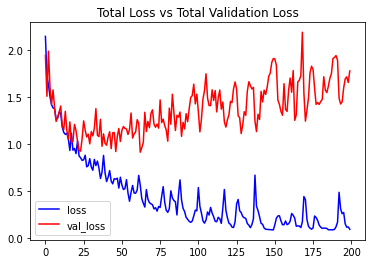

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(lstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

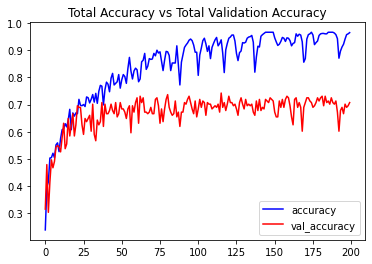

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(lstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
model.save('saved_model/my_model')